# Happy Customers Prediction

## Introduction

In this project, we will develop a machine learning model for a logistics and delivery company, meant to help them predict whether or not a customer will be happy with their delivery, along with what factors influence customer happiness the most. This is important because it will allow this company to better retain their customers, or to attract new ones, based on their track record of exemplary customer service and their efficient, effective practices.

To accomplish this, we will use a Bernoulli Naive Bayes Classifier, augmented with recursive feature elimination, to surpass our preset benchmark of 73% accuracy. And by the end, we will propose the solutions to our business problem, supported by the insights we have obtained through training and evaluating our model, and through analyzing our data.

## Our Data

Our data is a csv file of customer survey data with 126 rows and 7 columns. 6 of those columns are survey questions asking customers to rate various aspects of their experience on a scale from 1 to 5. And they are presented in the following data dictionary.

 - **X1**: My order was delivered on time.
 - **X2**: The contents of my order were what I expected.
 - **X3**: I was able to order everything I wanted.
 - **X4**: I paid a good price for my order.
 - **X5**: I am satisfied with my Courier.
 - **X6**: The app makes ordering easy for me.
 - **Y**: Our target. A binary column with 0 indicating the customer was not happy with their experience and 1 indicating the opposite.



## Data Preprocessing

Now, let us perform any necessary preprocessing on our data.

In [ ]:
import pandas as pd

data = pd.read_csv('/content/ACME-HappinessSurvey2020.csv')

data.head()

,Y,X1,X2,X3,X4,X5,X6
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Y       126 non-null    int64
 1   X1      126 non-null    int64
 2   X2      126 non-null    int64
 3   X3      126 non-null    int64
 4   X4      126 non-null    int64
 5   X5      126 non-null    int64
 6   X6      126 non-null    int64
dtypes: int64(7)
memory usage: 7.0 KB


In [ ]:
data.isna().sum()

Y     0
X1    0
X2    0
X3    0
X4    0
X5    0
X6    0
dtype: int64

In [ ]:
data.duplicated().sum()

16

### Observations:

From the results above we see that we have no missing values, but that we have a few duplicate rows. Let us investigate them further.

In [ ]:
duplicate_rows = data[data.duplicated()]
duplicate_rows

,Y,X1,X2,X3,X4,X5,X6
4,0,5,4,3,3,3,5
22,0,4,3,5,5,5,4
28,1,3,3,1,3,3,4
33,1,3,2,4,4,4,5
37,1,5,3,4,3,4,5
50,1,5,1,3,3,4,4
51,1,5,1,3,3,4,4
53,1,5,2,4,3,4,5
55,1,4,3,2,4,3,4
62,1,5,2,4,4,5,5


### Observations:

We see that most duplicate rows are positive responses. Many of them might be due to different customers having the same responses, and so we will not remove them.

## Exploratory Data Analysis

Now that we have preprocessed our data, let us perform some Exploratory Data Analysis to understand our data and extract insights from it before training our model. To do this, let us import some libararies we will need, and then define a helper function that will visualize each our features.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# colors we will use
colors = sns.color_palette('pastel')[:6]

def plot_hist_and_box(df, col, color, figsize=(10,10)):
  """
  Plots a histogram and a boxplot for a given column in a DataFrame.
  Args:
    df (DataFrame): The DataFrame containing the column to be plotted.
    col (str): The name of the column to be plotted.
    color (str): The color of the histogram and boxplot.
  """
  fig, axs = plt.subplots(2, 1, figsize=figsize, gridspec_kw=dict(height_ratios=[0.15, 0.85]))
  sns.boxplot(data=df, x=col, ax=axs[0], showmeans=True, color=color)
  sns.histplot(data=df, x=col, ax=axs[1], kde=True, color=color)
  axs[1].axvline(df[col].mean(), color='green', linestyle='--')
  axs[1].axvline(df[col].median(), color='red', linestyle='--')
  axs[1].annotate(
      f'Mean: {df[col].mean():.2f}\nMedian: {df[col].median():.2f}',
      xy=(0.15, 0.95), xycoords='axes fraction',
      ha='right', va='top', fontsize=12, color='black'
  )
  axs[0].set(
      xlabel='',
      ylabel='',
      title=f'{col} Distribution'
  )
  axs[1].set(
      xlabel=col,
      ylabel='Count',
      title=''
  )
  plt.show()
  plt.clf()

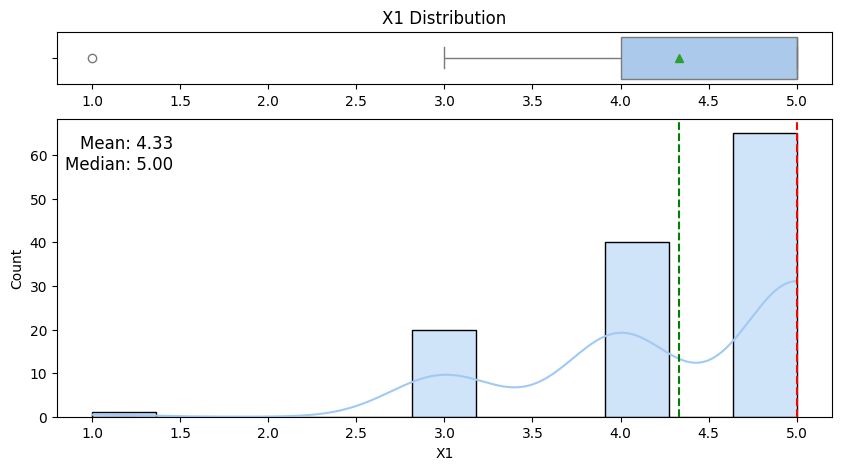

<Figure size 640x480 with 0 Axes>

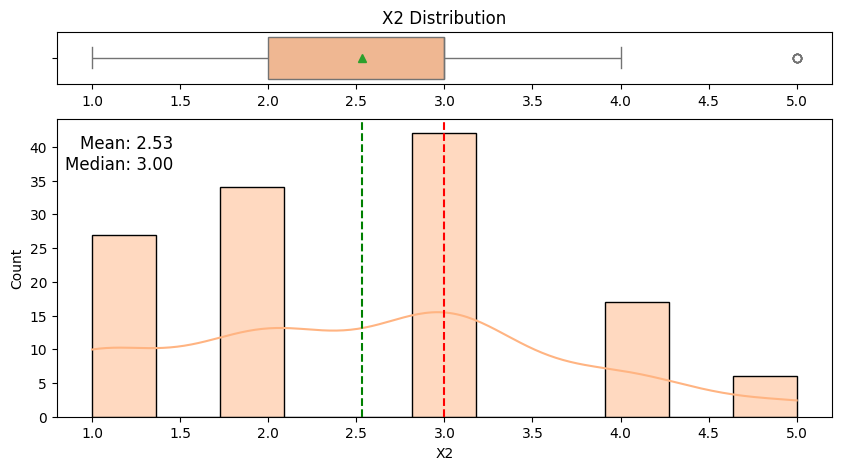

<Figure size 640x480 with 0 Axes>

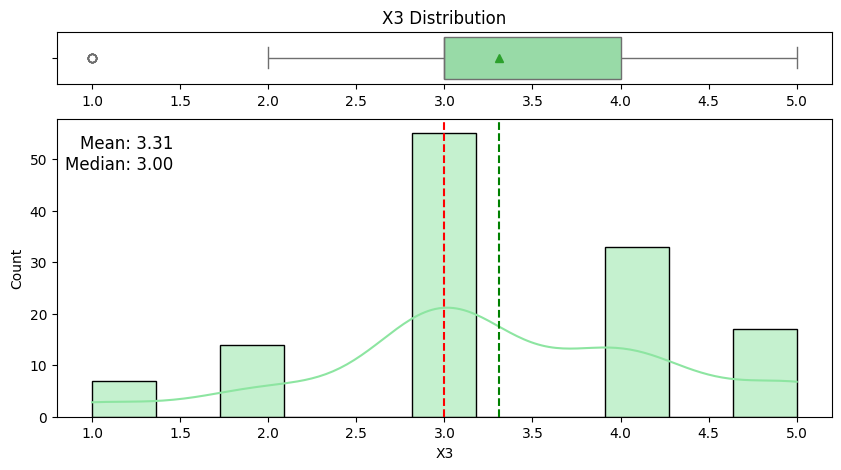

<Figure size 640x480 with 0 Axes>

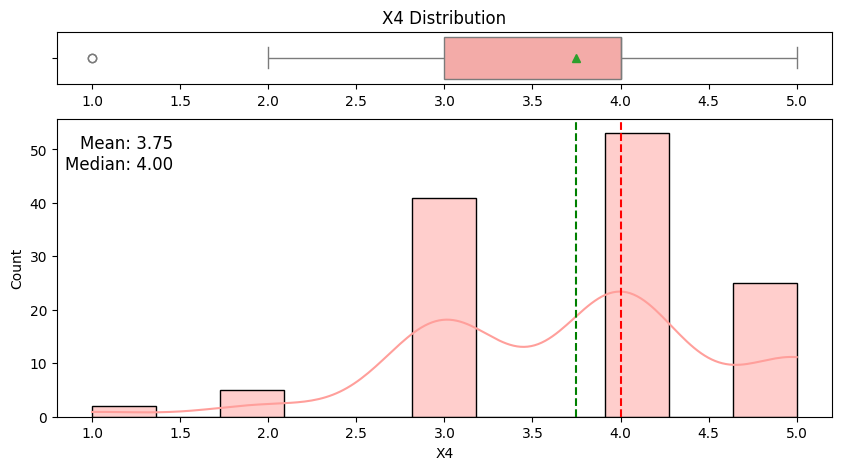

<Figure size 640x480 with 0 Axes>

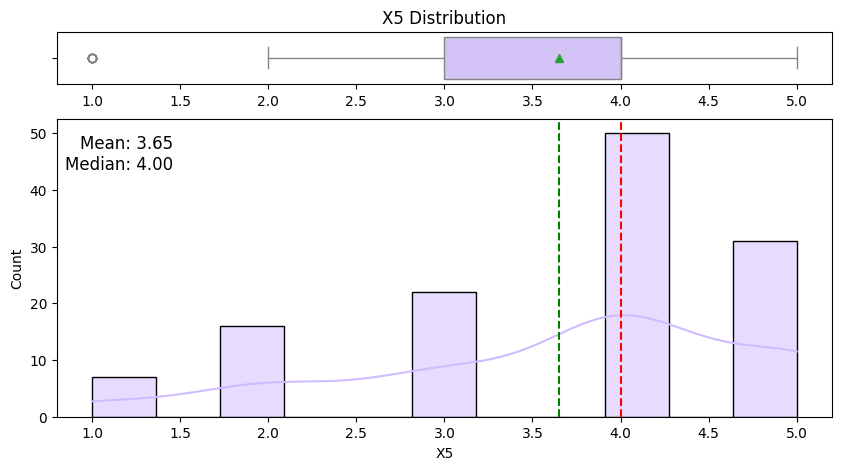

<Figure size 640x480 with 0 Axes>

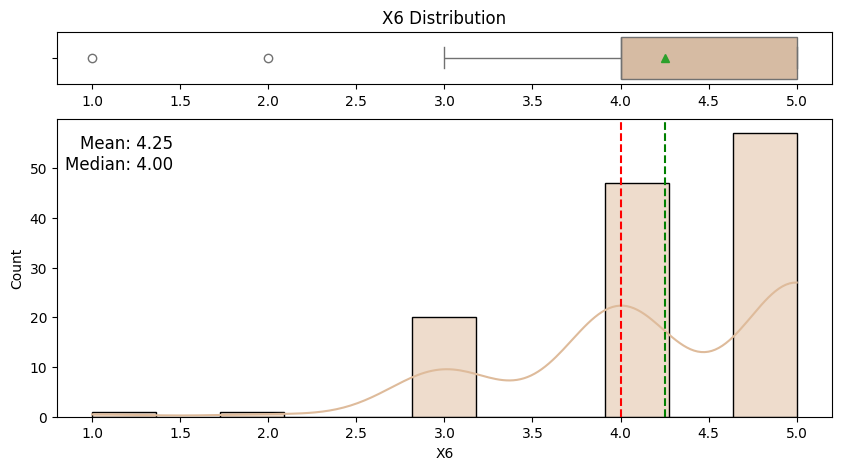

<Figure size 640x480 with 0 Axes>

In [ ]:
for i, col in enumerate(['X1', 'X2', 'X3', 'X4', 'X5', 'X6']):
  plot_hist_and_box(data, col, colors[i], figsize=(10, 5))

### Observations:

We see that most customers recieved their orders on time, paid a fair price for it, and had a pleasant experience with their courier and with the app from which they ordered from. However, it seems that many customers had a mediocre experience getting the items they wanted. This might be worth investigating further. Now that we have explored our features as single variables, let us visualize the distribution of our target variable.

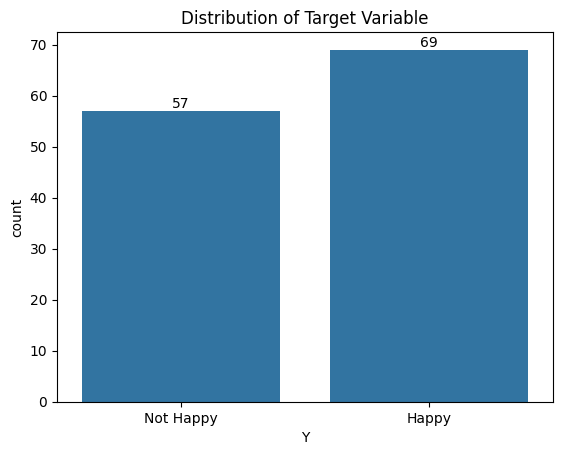

In [ ]:
plt.figure()
sns.countplot(data=data, x='Y')
plt.xticks([0, 1], ['Not Happy', 'Happy'])
plt.title('Distribution of Target Variable')
for p in plt.gca().patches:
  height = p.get_height()
  plt.gca().annotate(f'{height:.0f}', (p.get_x() + p.get_width() / 2, height), ha='center', va='bottom')
plt.show()

### Observations:

It seems our classes are balanced. This is good because it will allow our model to learn the patterns contributing to each equally. Now, let us do a bivariate analysis to explore how are features and target are connected.

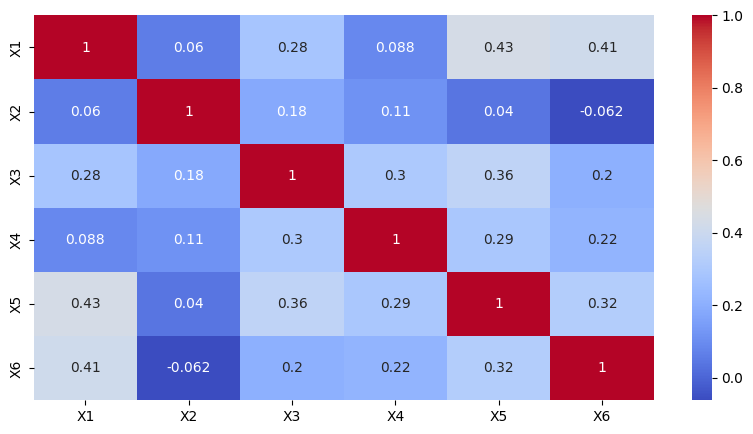

In [ ]:
plt.figure(figsize=(10, 5))
sns.heatmap(data[['X1', 'X2', 'X3', 'X4', 'X5', 'X6']].corr(), annot=True, cmap='coolwarm')
plt.show()

### Observations:

It seems many of the features in our dataset our correlated, especially the customer's rating on whether they recieved their order on time with the experience they had with their courier and the app. But with recursive feature elimination, we can minimize the effects of multicollinearity.

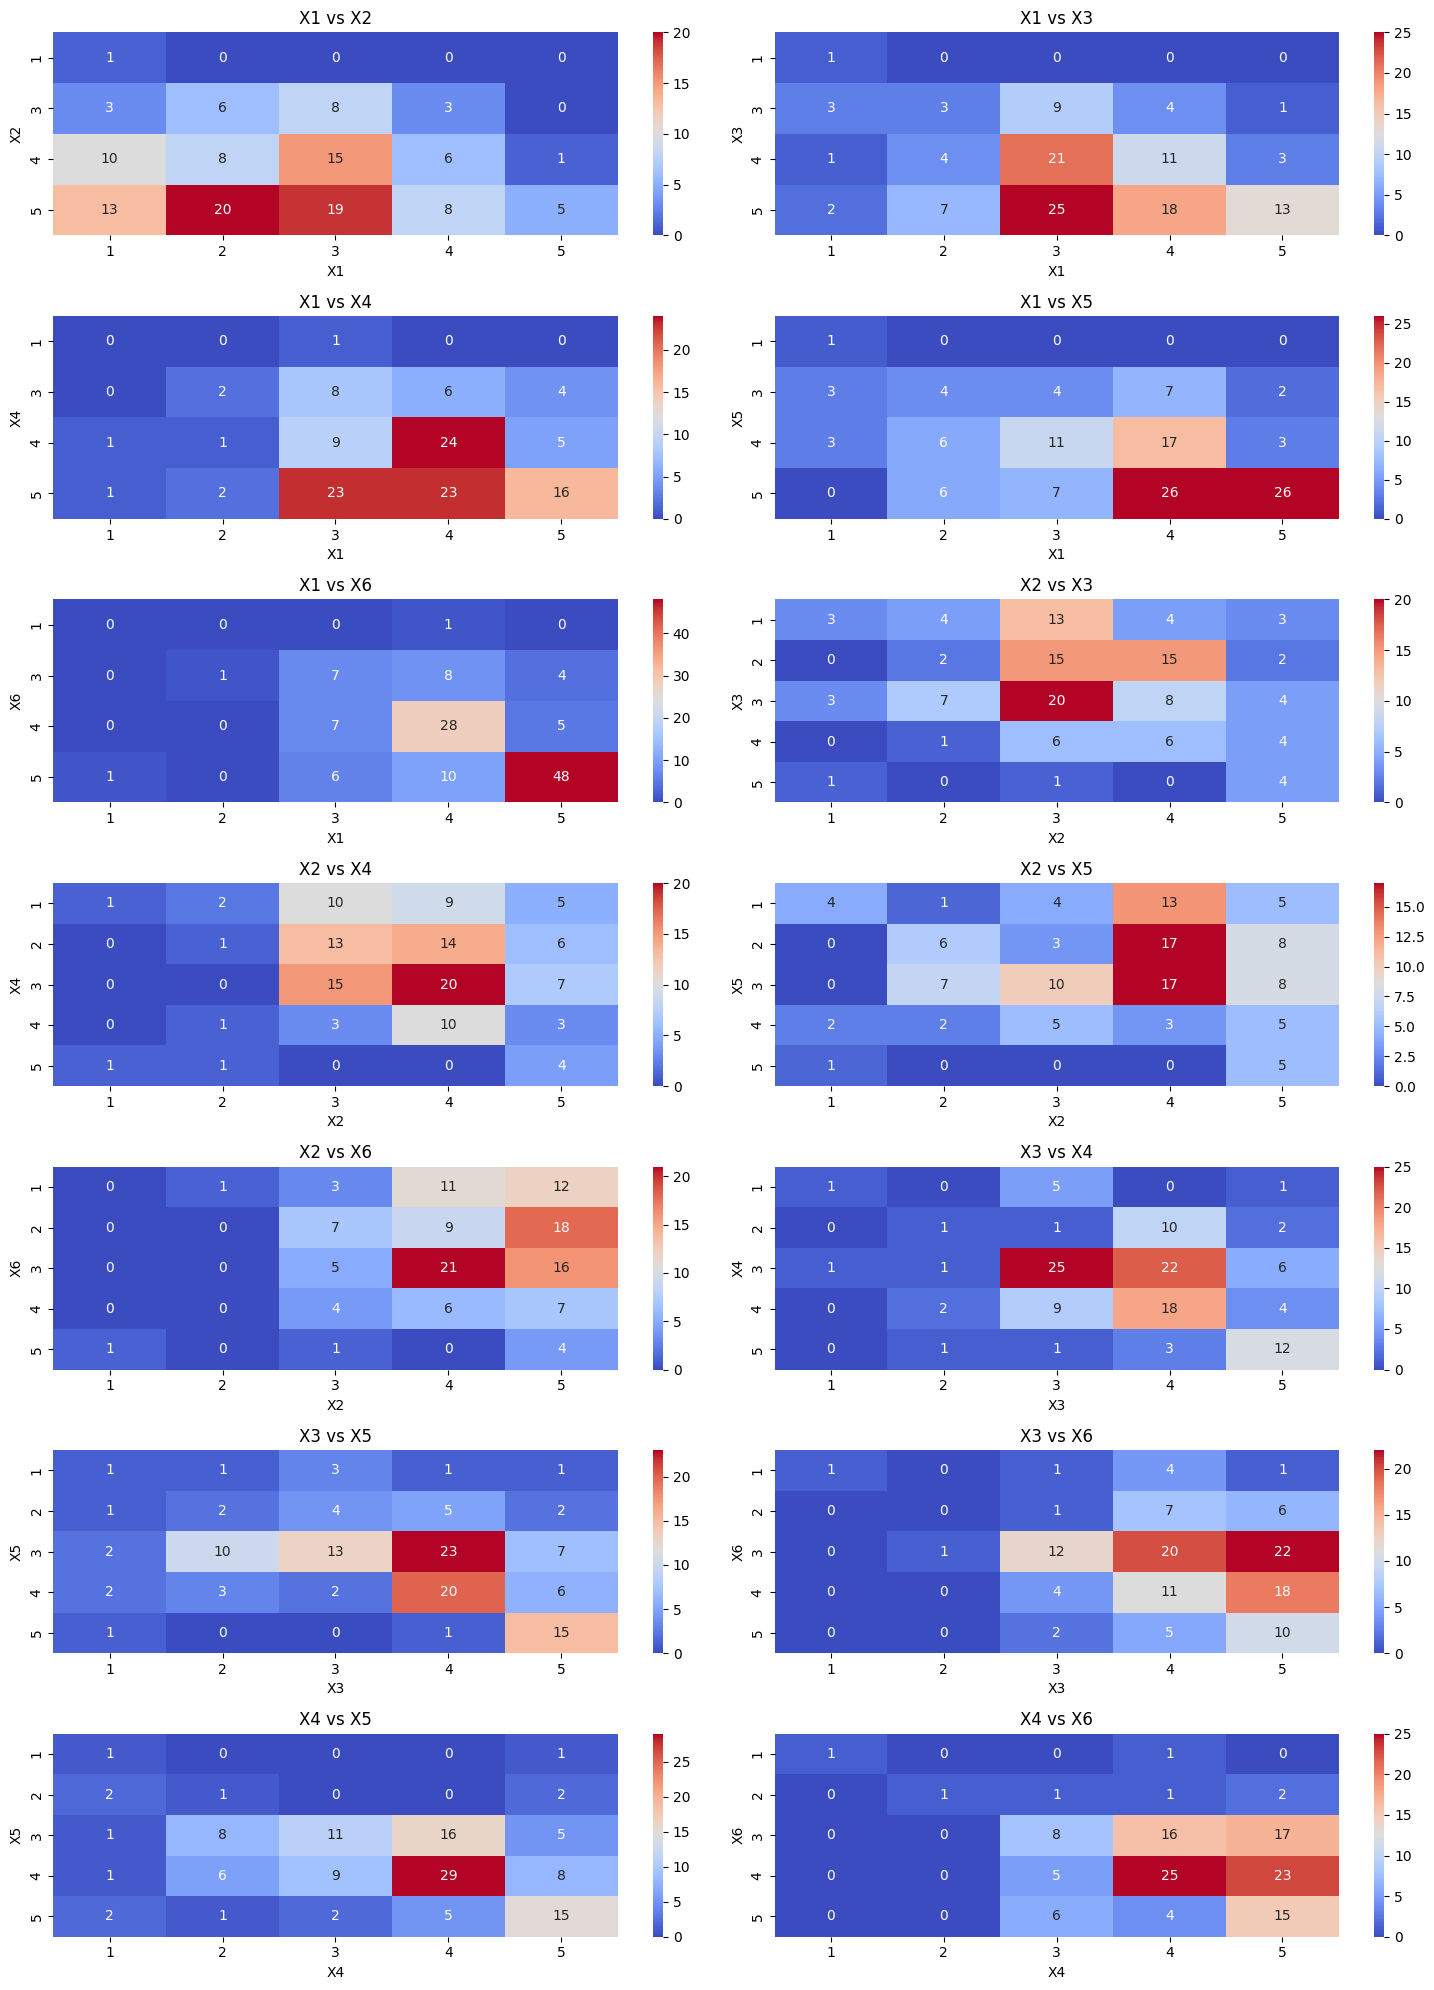

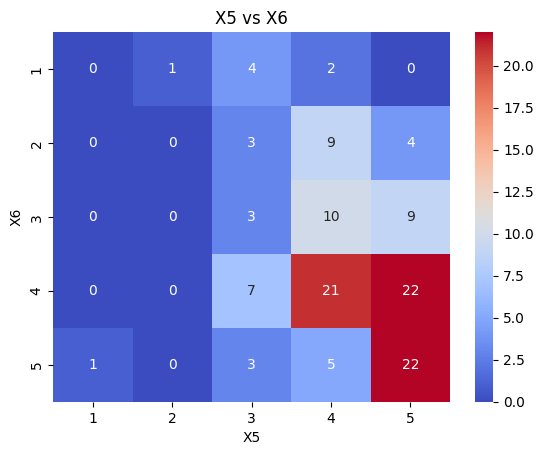

In [ ]:
from itertools import combinations

cols = list(data.columns)
cols.remove('Y')

combos = list(combinations(cols, 2))

crosstabs = {}

for combo in combos:
  crosstabs[combo] = pd.crosstab(
      index=data[combo[0]],
      columns=data[combo[1]],
      values=data['Y'],
      aggfunc='count'
  ).fillna(0)

plt.figure(figsize=(15, 20))

for i, combo in enumerate(combos):
  try:
    plt.subplot(len(combos)//2, 2, i + 1)
    sns.heatmap(crosstabs[combo], annot=True, cmap='coolwarm')
    plt.title(f'{combo[0]} vs {combo[1]}')
    plt.xlabel(combo[0])
    plt.ylabel(combo[1])
  except:
    plt.tight_layout()
    plt.figure()
    sns.heatmap(crosstabs[combo], annot=True, cmap='coolwarm')
    plt.title(f'{combo[0]} vs {combo[1]}')
    plt.xlabel(combo[0])
    plt.ylabel(combo[1])
    plt.show()


### Observations:

From the heatmaps above, we see that the values of `X1`, `X3`, and `X6` seem to play a noticeable role in customer happiness. This suggests that customers are happiest when they are able to order what they want, and when their orders arrive on time.

## Model Training

Now that we have finished exploring our data, let's finally train our model.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import RFE
from sklearn.naive_bayes import BernoulliNB


X = data.drop('Y', axis=1)
y = data['Y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

model = Pipeline(
    steps=[
        ('scaler', StandardScaler()),
        ('rfe', RFE(
            estimator=BernoulliNB(),
            n_features_to_select=3,
            importance_getter='feature_log_prob_'
        )),
        ('bnb', BernoulliNB())
    ]
)

model.fit(X_train, y_train)



Pipeline(steps=[('scaler', StandardScaler()),
                ('rfe',
                 RFE(estimator=BernoulliNB(),
                     importance_getter='feature_log_prob_',
                     n_features_to_select=3)),
                ('bnb', BernoulliNB())])

## Model Evaluation and Interpretation

Now that we have trained our model, let us evaluate it and find the features our Recursive Feature Eliminator selected as the most important.

In [ ]:
y_pred = model.predict(X_test)

metrics = {
    'accuracy': accuracy_score(y_test, y_pred),
    'precision': precision_score(y_test, y_pred),
    'recall': recall_score(y_test, y_pred),
    'f1': f1_score(y_test, y_pred)
}

metrics

{'accuracy': 0.7307692307692307,
 'precision': 0.7333333333333333,
 'recall': 0.7857142857142857,
 'f1': 0.7586206896551724}

In [ ]:
features_used_ind = model.named_steps['rfe'].support_

features_used = X.columns[features_used_ind]

features_used

Index(['X1', 'X3', 'X6'], dtype='object')

### Observations:

It seems the most important features are:

  - Whether the customer's order arrived on time.
  - Whether the customer was able to order everything they wanted.
  - Whether the app made it easy for the customer to make their orders.


## Recommendations

In the future I recommend that:

  - The business ensures that all orders arrive on time.
  - That warehouses remain fully stocked.
  - That the business invests in making the UI/UX of their app as intuitive and as easy to use as possible for customers.